In [1]:
!wget --header 'Host: doc-0c-1k-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Cookie: AUTH_csdjgvpst22uelm6baj76hav932efism_nonce=sub8qqns01cn6' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0c-1k-docs.googleusercontent.com/docs/securesc/jagppijtrb6btv4lqfjr0bmqujr0tjj4/veomppdpdkdl9tb5j5dkp2rnlg9ao7e7/1606650225000/15262444124766430801/15262444124766430801/1PYTWabfiDIvS8SQvAKBySUvCcU7wcqEK?e=download&authuser=1&nonce=sub8qqns01cn6&user=15262444124766430801&hash=elofv4fiehlbbp9h68uo6gcfakfqc1c9' --output-document 'data_augmentation_1.zip'

--2020-11-29 11:45:02--  https://doc-0c-1k-docs.googleusercontent.com/docs/securesc/jagppijtrb6btv4lqfjr0bmqujr0tjj4/veomppdpdkdl9tb5j5dkp2rnlg9ao7e7/1606650225000/15262444124766430801/15262444124766430801/1PYTWabfiDIvS8SQvAKBySUvCcU7wcqEK?e=download&authuser=1&nonce=sub8qqns01cn6&user=15262444124766430801&hash=elofv4fiehlbbp9h68uo6gcfakfqc1c9
Resolving doc-0c-1k-docs.googleusercontent.com (doc-0c-1k-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-1k-docs.googleusercontent.com (doc-0c-1k-docs.googleusercontent.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data_augmentation_1.zip’

data_augmentation_1     [       <=>          ] 171.97M  97.8MB/s    in 1.8s    

2020-11-29 11:45:04 (97.8 MB/s) - ‘data_augmentation_1.zip’ saved [180323258]



In [2]:
!unzip data_augmentation_1

Streaming output truncated to the last 5000 lines.
  inflating: data_augmentation_1/data_1/train/not_damaged/0569.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0569_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0570.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0570_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0571.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0571_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0572.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0572_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0573.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0573_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0574.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0574_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0575.jpg  
  inflatin

### Importing Libraries

In [4]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [4]:
#Creating a folder to save models
os.mkdir('vgg19')

In [5]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [6]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [7]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [8]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [9]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [10]:
vgg19_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Orginal Data

In [11]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [12]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## VGG19

### Baseline Model

In [13]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [14]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [15]:
#Importing vgg19 model and setting layers as non trainable
vgg19 = applications.VGG19(include_top = False,weights = 'imagenet',input_shape=(256,256,3))
vgg19 = non_trainable(vgg19)
fc = Flatten()(vgg19.output)
model_vgg19 = Model(inputs = vgg19.input,outputs = fc)

80142336/80134624 [==============================] - 0s 0us/step


### Stage 1

In [16]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [17]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg19,train_data_dir, test_data_dir)

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [18]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [19]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [20]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

 14%|█▍        | 1/7 [00:12<01:16, 12.68s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 29%|██▊       | 2/7 [00:26<01:05, 13.11s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Accuracy for alpha 0.0001 is  0.9524456521739131
Accuracy for alpha 0.001 is  0.9510869565217391
Accuracy for alpha 0.01 is  0.9497282608695652
Accuracy for alpha 0.1 is  0.9483695652173914
Accuracy for alpha 1 is  0.9470108695652174
Accuracy for alpha 10 is  0.9456521739130435
Accuracy for alpha 100 is  0.9483695652173914


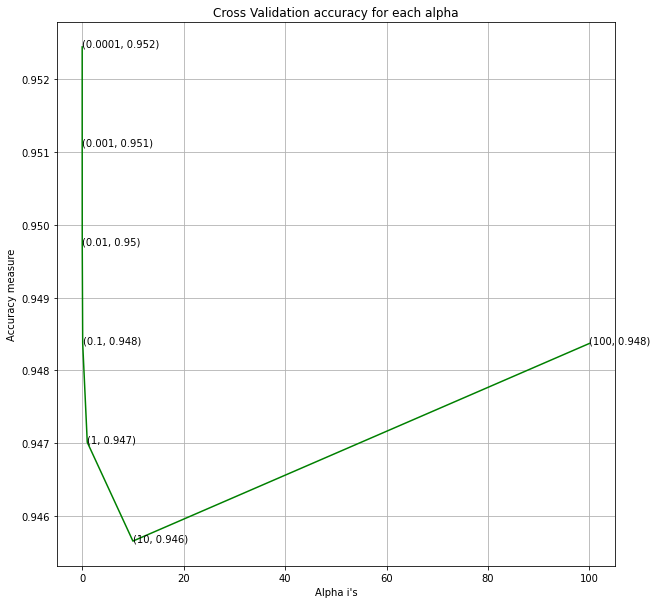

In [21]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

Accuracy on test data for final baseline model 0.9304347826086956
Precision on test data for final baseline model 0.9267241379310345
Recall on test data for final baseline model 0.9347826086956522
-------------------------------------------------- Confusion matrix --------------------------------------------------


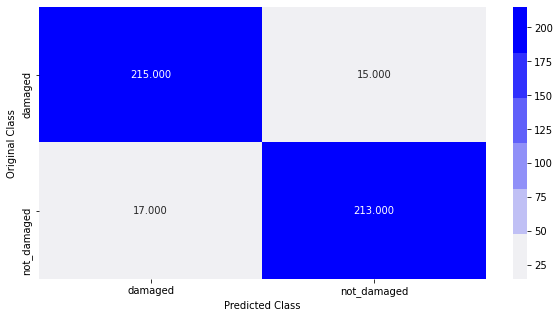

In [22]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg19/vgg19_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [16]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage1_baseline','Accuracy':'0.930','Precision':'0.927','Recall':'0.935'},ignore_index= True)

### Stage 2

In [24]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [25]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg19,train_data_dir, test_data_dir)

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [26]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [27]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [28]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [00:24<02:24, 24.12s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


Accuracy for alpha 0.0001 is  0.799492385786802
Accuracy for alpha 0.001 is  0.8045685279187818
Accuracy for alpha 0.01 is  0.8045685279187818
Accuracy for alpha 0.1 is  0.8045685279187818
Accuracy for alpha 1 is  0.7944162436548223
Accuracy for alpha 10 is  0.7969543147208121
Accuracy for alpha 100 is  0.7969543147208121


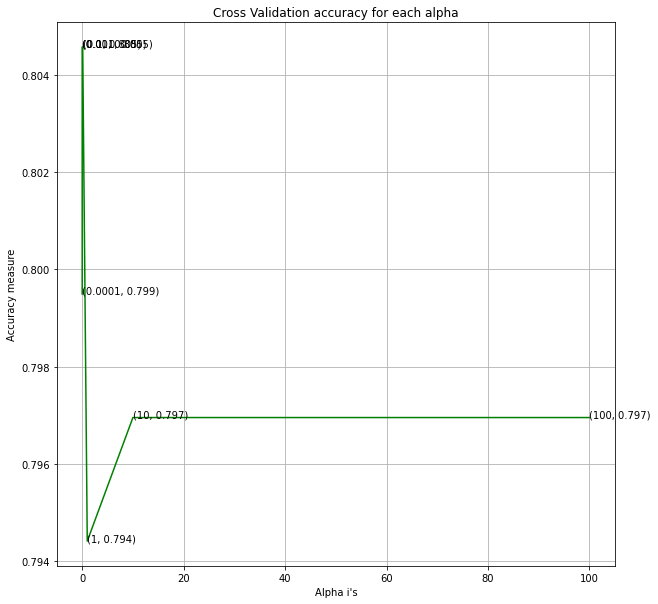

In [29]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.7318435754189944
Average Precision is 0.7460070984915705
Average Recall is 0.7298620952081037
-------------------------------------------------- Confusion Matrix --------------------------------------------------


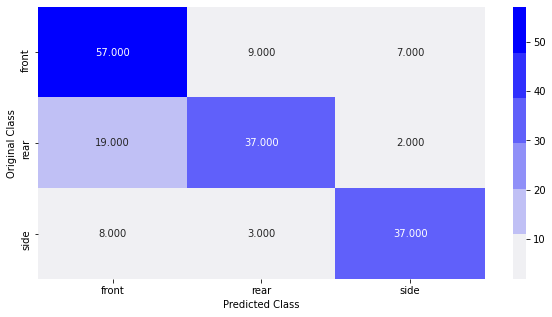

-------------------------------------------------- Precision Matrix --------------------------------------------------


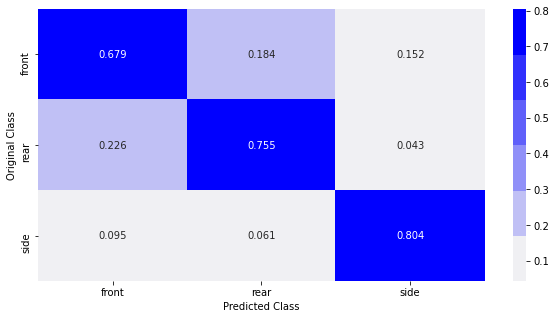

-------------------------------------------------- Recall Matrix --------------------------------------------------


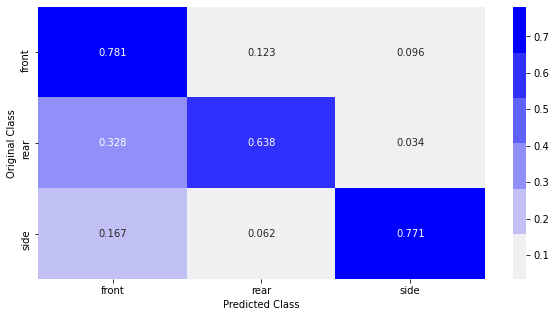

In [30]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'vgg19/vgg19_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [17]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage2_baseline','Accuracy':'0.732','Precision':'0.746','Recall':'0.730'},ignore_index= Truevgg19_scores

### Stage 3

In [32]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [33]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg19,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [34]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [35]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [36]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [00:25<02:35, 25.92s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


Accuracy for alpha 0.0001 is  0.8239795918367347
Accuracy for alpha 0.001 is  0.826530612244898
Accuracy for alpha 0.01 is  0.8239795918367347
Accuracy for alpha 0.1 is  0.8163265306122449
Accuracy for alpha 1 is  0.8112244897959183
Accuracy for alpha 10 is  0.8086734693877551
Accuracy for alpha 100 is  0.8112244897959183


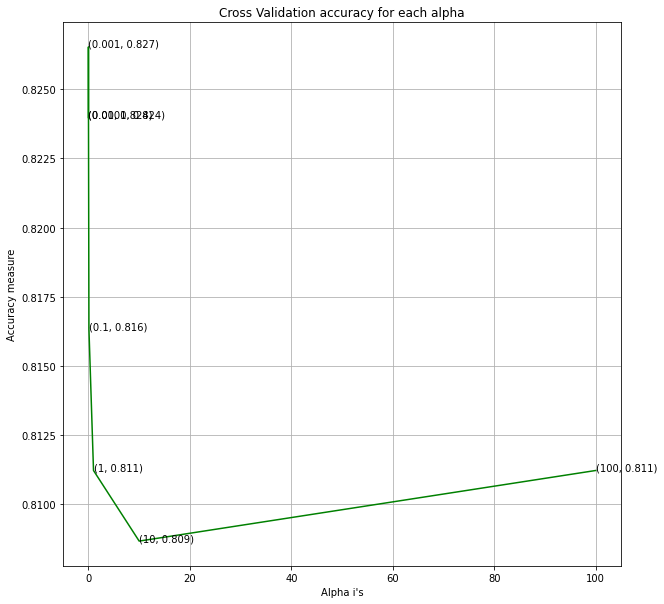

In [37]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.6549707602339181
Average Precision is 0.6412865497076023
Average Recall is 0.6462715389185978
-------------------------------------------------- Confusion Matrix --------------------------------------------------


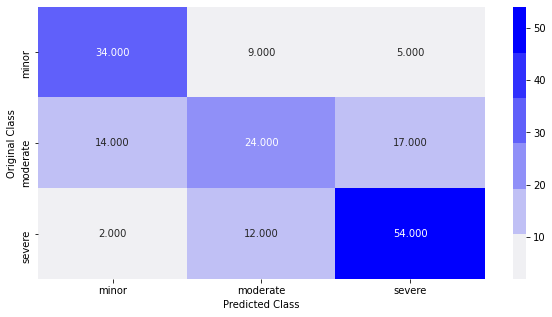

-------------------------------------------------- Precision Matrix --------------------------------------------------


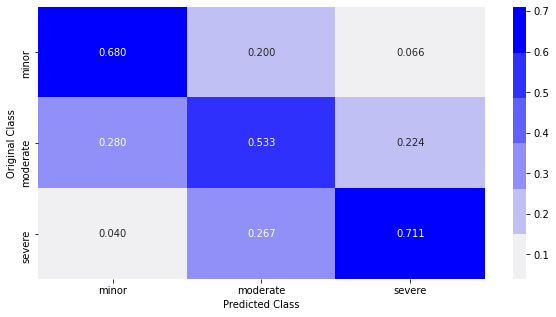

-------------------------------------------------- Recall Matrix --------------------------------------------------


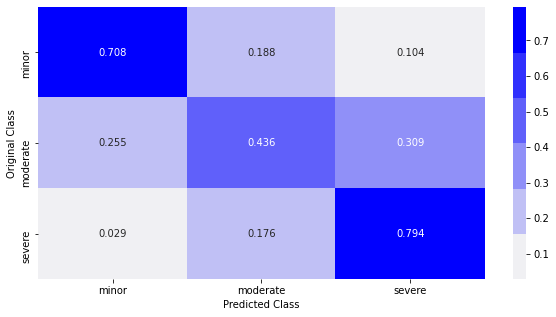

In [38]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg19/vgg19_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [19]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage3_baseline','Accuracy':'0.656','Precision':'0.641','Recall':'0.646'},ignore_index= True)

### CNN (Training FC layers only)

In [21]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg19 = applications.VGG19(include_top = False,weights = 'imagenet',input_tensor = input_layer)
    vgg19 = non_trainable(vgg19)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg19.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [41]:
model = create_model(1,'sigmoid')

In [42]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [43]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

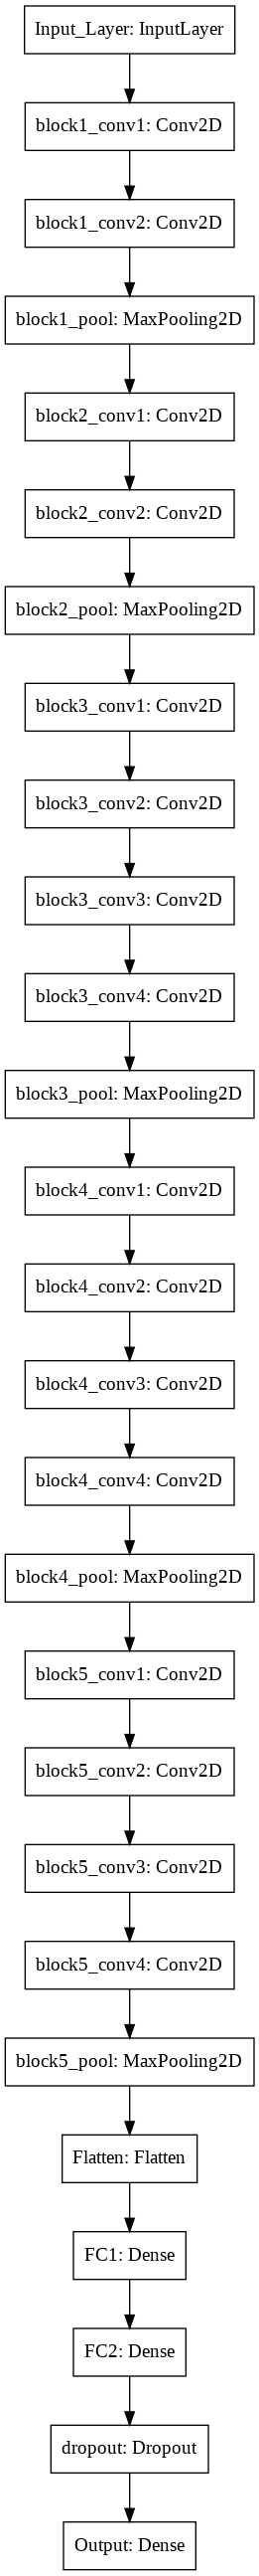

In [44]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [45]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [46]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [47]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [48]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - ETA: 0s - loss: 1.6221 - accuracy: 0.8136
Epoch 00001: val_accuracy improved from -inf to 0.90000, saving model to vgg19/vgg19_stage1_fc-0.900.hdf5
460/460 [==============================] - 43s 92ms/step - loss: 1.6221 - accuracy: 0.8136 - val_loss: 0.5567 - val_accuracy: 0.9000
Epoch 2/50
460/460 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.9139
Epoch 00002: val_accuracy did not improve from 0.90000
460/460 [==============================] - 40s 87ms/step - loss: 0.4279 - accuracy: 0.9139 - val_loss: 0.5571 - val_accuracy: 0.9000
Epoch 3/50
460/460 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9484
Epoch 00003: val_accuracy improved from 0.90000 to 0.91957, saving model to vgg19/vgg19_stage1_fc-0.920.hdf5
460/460 [==============================] - 41s 89ms/step - loss: 0.1812 - accuracy: 0.9484 - val_loss: 0.5296 - val_accuracy: 0.9196
Epoch 4/50
460/460 [=======================

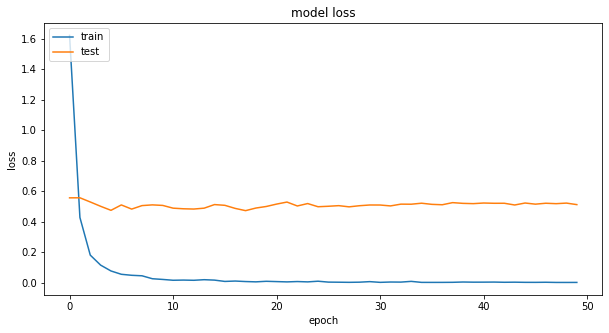

The loss for final model is  0.5125479698181152


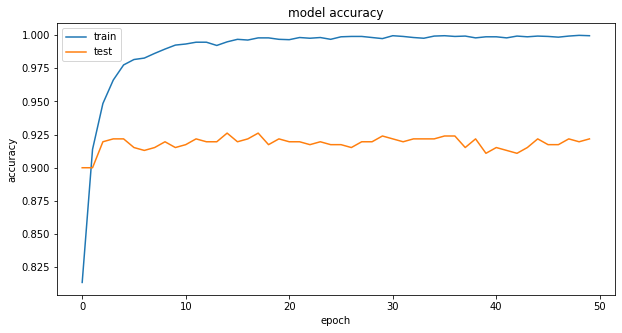

The accuracy for final model is  0.926086962223053


In [49]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [50]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [51]:
best_model = load_model('vgg19/vgg19_stage1_fc-0.926.hdf5')

In [52]:
y_pred = best_model.predict(x_test)

In [53]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9298245614035088
Recall on test data for final baseline model 0.9217391304347826
-------------------------------------------------- Confusion matrix --------------------------------------------------


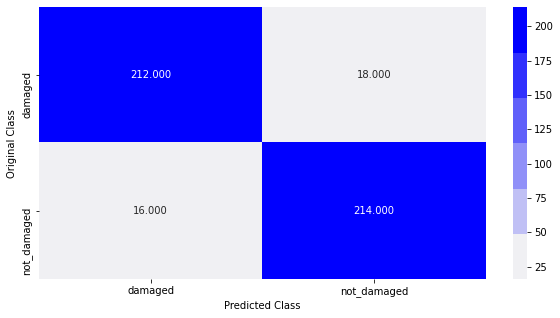

In [54]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [22]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage1 FC','Accuracy':'0.926','Precision':'0.930','Recall':'0.922'},ignore_index= True)

### Stage 2

In [23]:
model = create_model(3,'softmax')

In [24]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

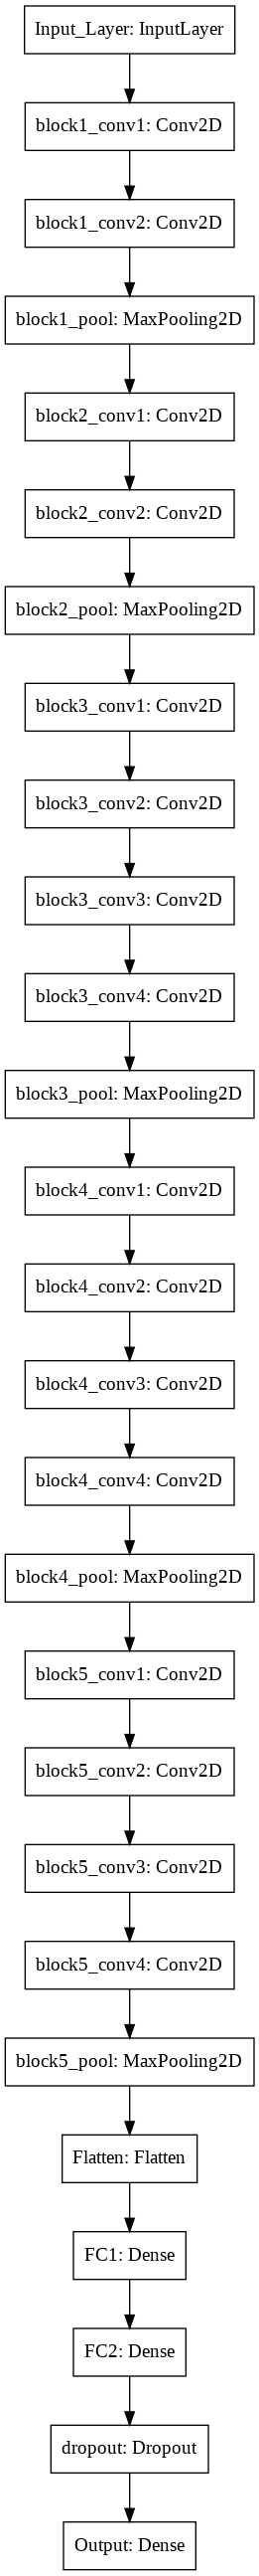

In [26]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [60]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [61]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [62]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [63]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 6.1782 - accuracy: 0.5036
Epoch 00001: val_accuracy improved from -inf to 0.56425, saving model to vgg19/vgg19_stage2_fc-0.564.hdf5
247/246 [==============================] - 22s 91ms/step - loss: 6.1782 - accuracy: 0.5036 - val_loss: 2.3460 - val_accuracy: 0.5642
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 1.2962 - accuracy: 0.7467
Epoch 00002: val_accuracy improved from 0.56425 to 0.64804, saving model to vgg19/vgg19_stage2_fc-0.648.hdf5
247/246 [==============================] - 21s 87ms/step - loss: 1.2962 - accuracy: 0.7467 - val_loss: 1.9183 - val_accuracy: 0.6480
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.8584
Epoch 00003: val_accuracy did not improve from 0.64804
247/246 [==============================] - 20s 81ms/step - loss: 0.5554 - accuracy: 0.8584 - val_loss: 1.9359 - val_accuracy: 0.6480
Epoch 4/50
247/246 [=======================

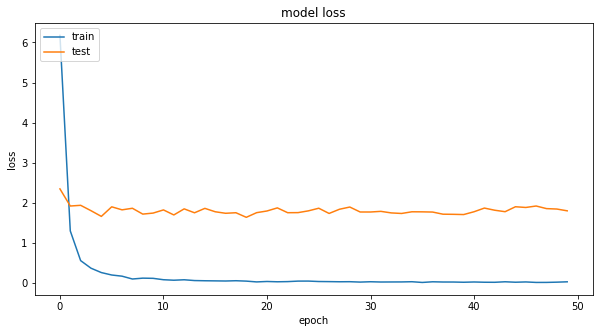

The loss for final model is  1.8472627401351929


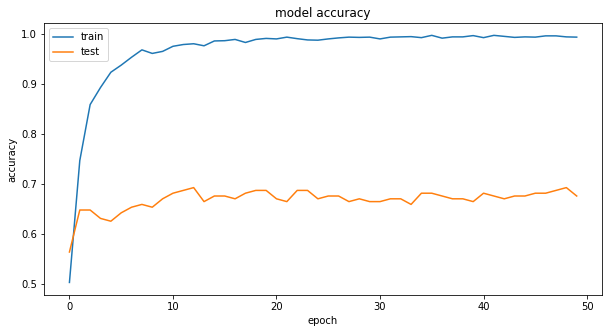

The accuracy for final model is  0.6927374005317688


In [64]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [65]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [66]:
best_model = load_model('vgg19/vgg19_stage2_fc-0.693.hdf5')

In [67]:
y_pred = best_model.predict(x_test)

In [68]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.7096073517126148
Average Recall is 0.6777410381567207
-------------------------------------------------- Confusion Matrix --------------------------------------------------


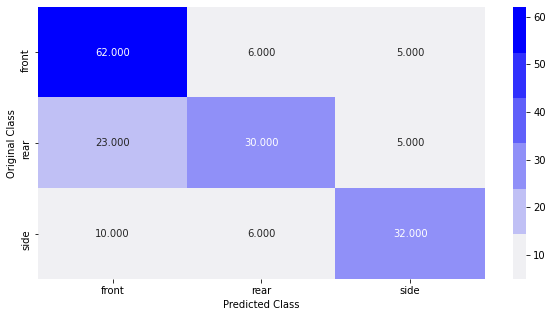

-------------------------------------------------- Precision Matrix --------------------------------------------------


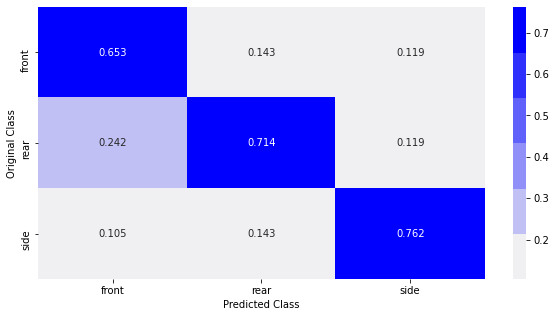

-------------------------------------------------- Recall Matrix --------------------------------------------------


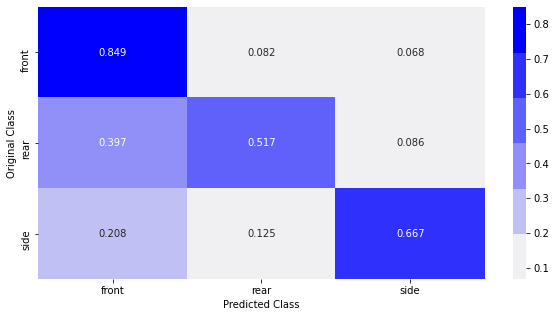

In [69]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [27]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage2 FC','Accuracy':'0.693','Precision':'0.710','Recall':'0.678'},ignore_index= True)

### Stage 3

In [28]:
model = create_model(3,'softmax')

In [29]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

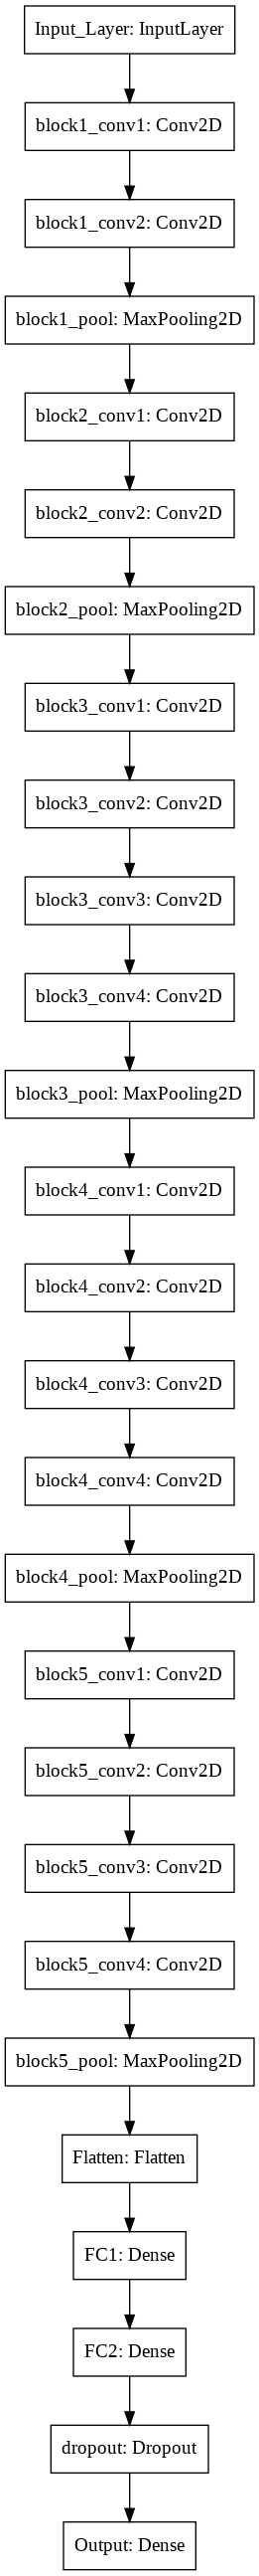

In [31]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [32]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [33]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [34]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [35]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 5.8380 - accuracy: 0.5082
Epoch 00001: val_accuracy improved from -inf to 0.53801, saving model to vgg19/vgg19_stage3_fc-0.538.hdf5
245/244 [==============================] - 21s 85ms/step - loss: 5.8380 - accuracy: 0.5082 - val_loss: 2.6776 - val_accuracy: 0.5380
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 1.2255 - accuracy: 0.7692
Epoch 00002: val_accuracy improved from 0.53801 to 0.58480, saving model to vgg19/vgg19_stage3_fc-0.585.hdf5
245/244 [==============================] - 20s 84ms/step - loss: 1.2255 - accuracy: 0.7692 - val_loss: 2.4792 - val_accuracy: 0.5848
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.8636
Epoch 00003: val_accuracy improved from 0.58480 to 0.59649, saving model to vgg19/vgg19_stage3_fc-0.596.hdf5
245/244 [==============================] - 21s 87ms/step - loss: 0.5310 - accuracy: 0.8636 - val_loss: 2.2329 - val_accura

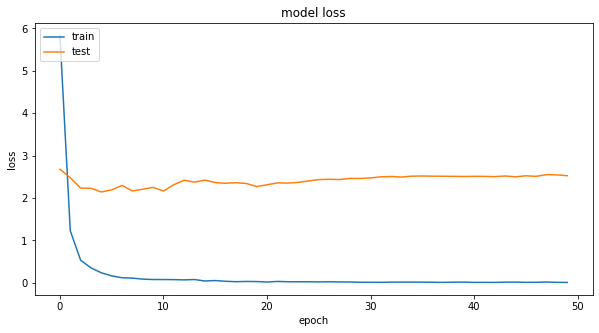

The loss for final model is  2.163287878036499


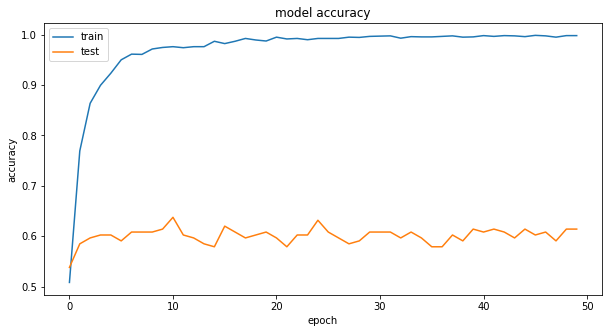

The accuracy for final model is  0.6374269127845764


In [36]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [37]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [38]:
best_model = load_model('vgg19/vgg19_stage3_fc-0.637.hdf5')

In [39]:
y_pred = best_model.predict(x_test)

In [40]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6329226005838232
Average Recall is 0.6262626262626263
-------------------------------------------------- Confusion Matrix --------------------------------------------------


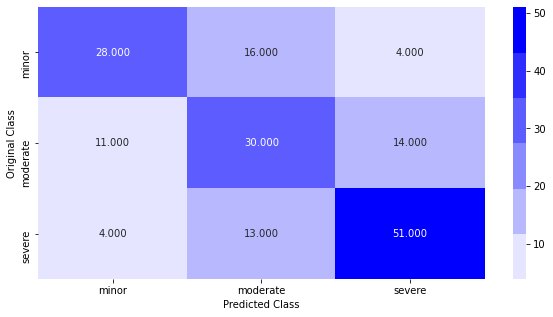

-------------------------------------------------- Precision Matrix --------------------------------------------------


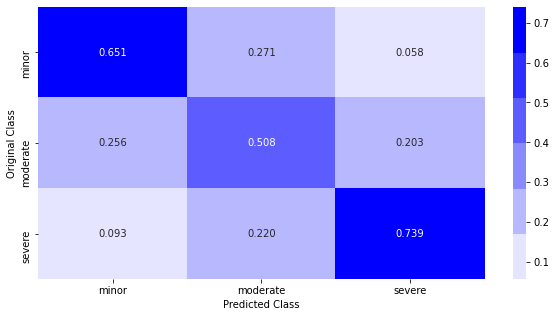

-------------------------------------------------- Recall Matrix --------------------------------------------------


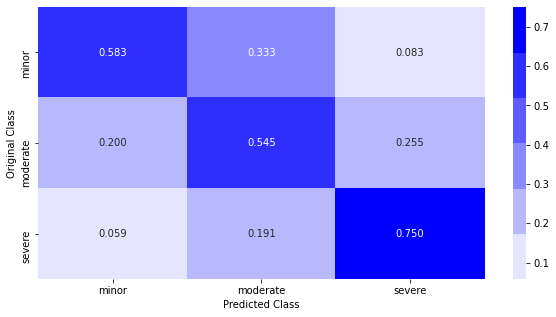

In [42]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [43]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage3 FC','Accuracy':'0.637','Precision':'0.633','Recall':'0.626'},ignore_index= True)

### CNN (Training All layers only)

In [44]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg19 = applications.VGG19(include_top = False,weights = 'imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg19.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [46]:
model = create_model(1,'sigmoid')

In [47]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [48]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

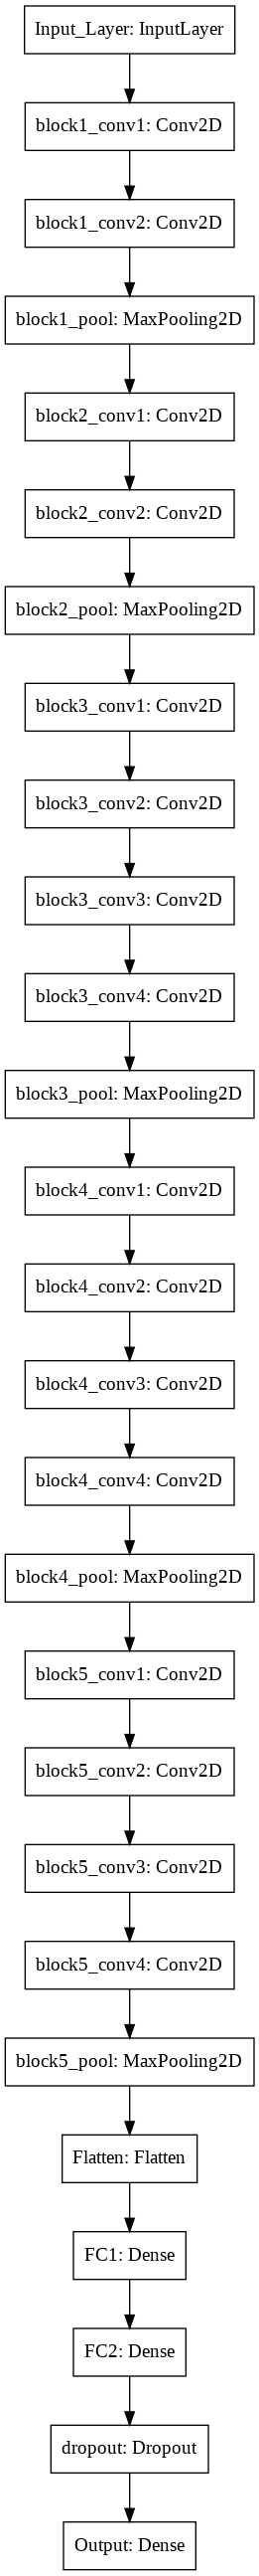

In [49]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [50]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [51]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [52]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [53]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.7851
Epoch 00001: val_accuracy improved from -inf to 0.87826, saving model to vgg19/vgg19_stage1_all-0.878.hdf5
460/460 [==============================] - 106s 231ms/step - loss: 0.7215 - accuracy: 0.7851 - val_loss: 0.2936 - val_accuracy: 0.8783
Epoch 2/50
460/460 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.8918
Epoch 00002: val_accuracy improved from 0.87826 to 0.90652, saving model to vgg19/vgg19_stage1_all-0.907.hdf5
460/460 [==============================] - 106s 229ms/step - loss: 0.2634 - accuracy: 0.8918 - val_loss: 0.2287 - val_accuracy: 0.9065
Epoch 3/50
460/460 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9264
Epoch 00003: val_accuracy improved from 0.90652 to 0.92391, saving model to vgg19/vgg19_stage1_all-0.924.hdf5
460/460 [==============================] - 105s 229ms/step - loss: 0.1868 - accuracy: 0.9264 - val_loss: 0.2279 - v

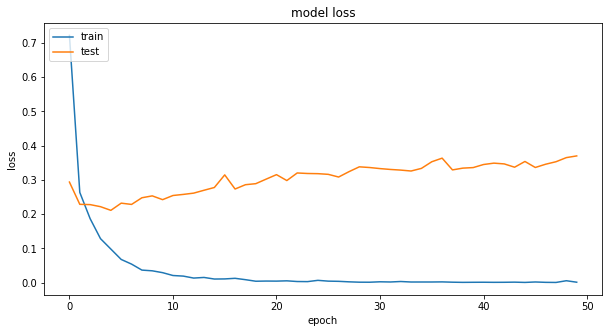

The loss for final model is  0.32585635781288147


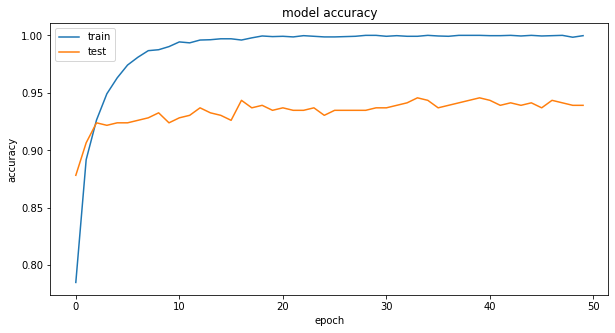

The accuracy for final model is  0.945652186870575


In [54]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [55]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [56]:
best_model = load_model('vgg19/vgg19_stage1_all-0.946.hdf5')

In [57]:
y_pred = best_model.predict(x_test)

In [58]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9437229437229437
Recall on test data for final baseline model 0.9478260869565217
-------------------------------------------------- Confusion matrix --------------------------------------------------


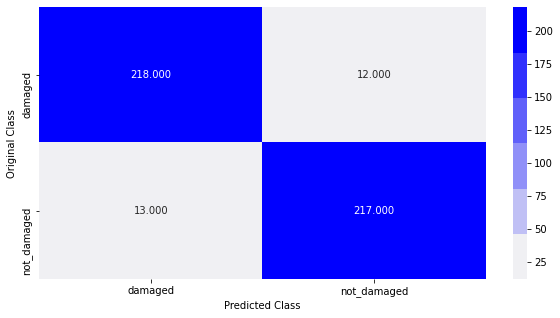

In [59]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [60]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage1 all','Accuracy':'0.946','Precision':'0.944','Recall':'0.948'},ignore_index= True)

### Stage 2

In [61]:
model = create_model(3,'softmax')

In [62]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [63]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

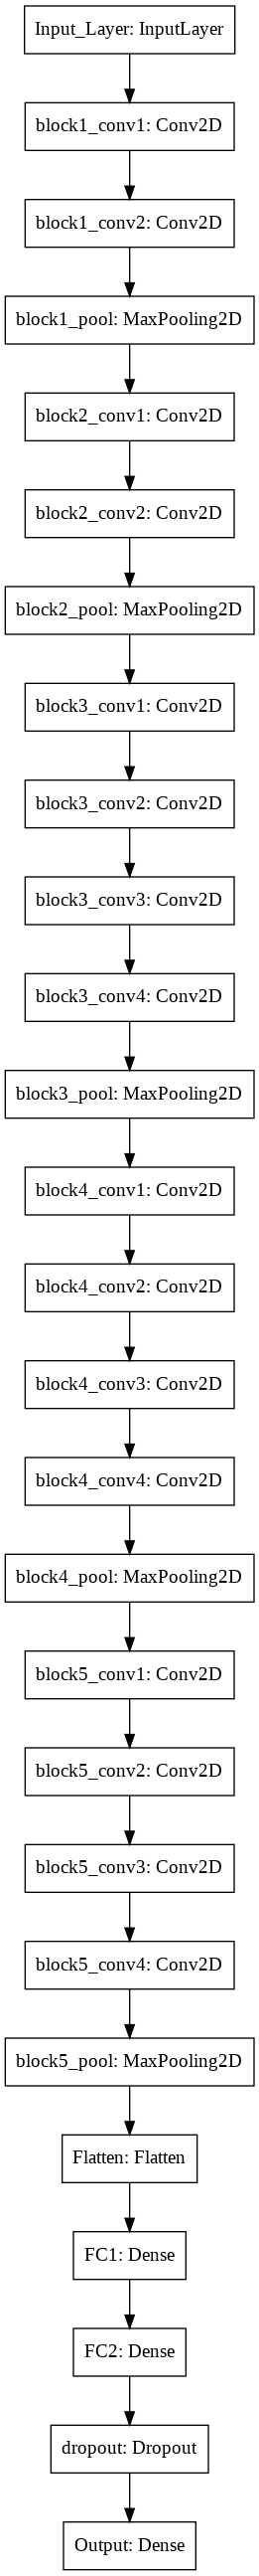

In [64]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [65]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [66]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [67]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [68]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 1.7706 - accuracy: 0.4020
Epoch 00001: val_accuracy improved from -inf to 0.36872, saving model to vgg19/vgg19_stage2_all-0.369.hdf5
247/246 [==============================] - 52s 212ms/step - loss: 1.7706 - accuracy: 0.4020 - val_loss: 1.0759 - val_accuracy: 0.3687
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 1.0444 - accuracy: 0.4563
Epoch 00002: val_accuracy improved from 0.36872 to 0.45251, saving model to vgg19/vgg19_stage2_all-0.453.hdf5
247/246 [==============================] - 53s 214ms/step - loss: 1.0444 - accuracy: 0.4563 - val_loss: 1.0676 - val_accuracy: 0.4525
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 0.9769 - accuracy: 0.5310
Epoch 00003: val_accuracy improved from 0.45251 to 0.46927, saving model to vgg19/vgg19_stage2_all-0.469.hdf5
247/246 [==============================] - 54s 219ms/step - loss: 0.9769 - accuracy: 0.5310 - val_loss: 1.0275 - val_

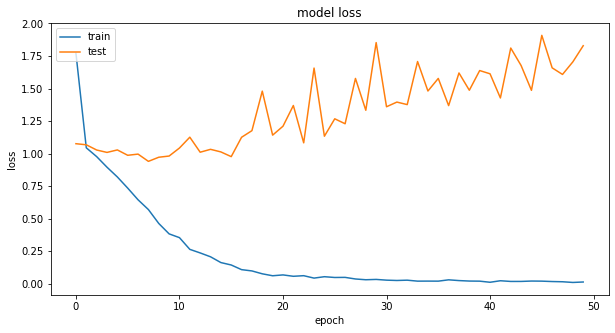

The loss for final model is  1.4272770881652832


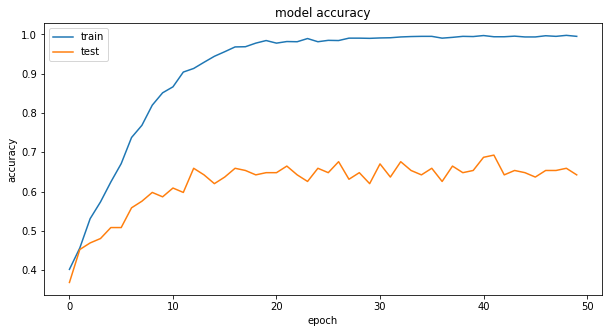

The accuracy for final model is  0.6927374005317688


In [69]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [70]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [71]:
best_model = load_model('vgg19/vgg19_stage2_all-0.693.hdf5')

In [72]:
y_pred = best_model.predict(x_test)

In [73]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.7117145235122763
Average Recall is 0.6776918333070907
-------------------------------------------------- Confusion Matrix --------------------------------------------------


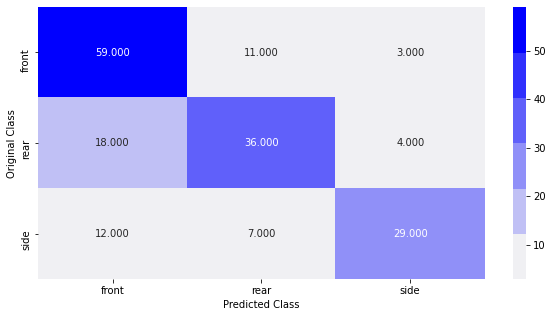

-------------------------------------------------- Precision Matrix --------------------------------------------------


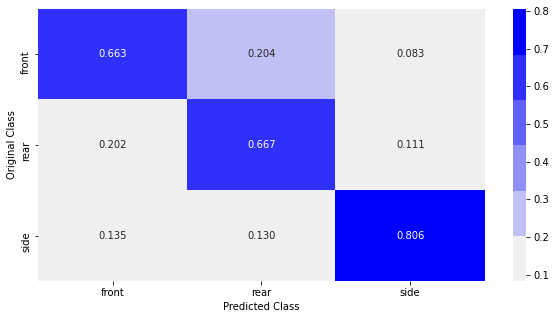

-------------------------------------------------- Recall Matrix --------------------------------------------------


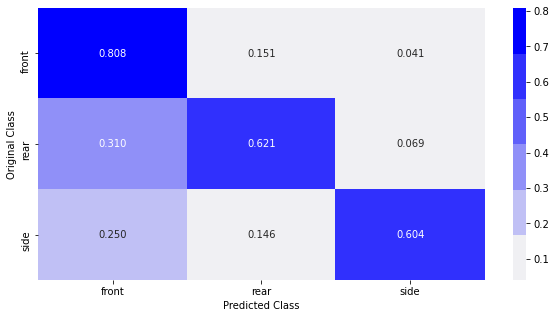

In [74]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [75]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage2 all','Accuracy':'0.693','Precision':'0.712','Recall':'0.678'},ignore_index= True)

### Stage 3

In [76]:
model = create_model(3,'softmax')

In [77]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [78]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

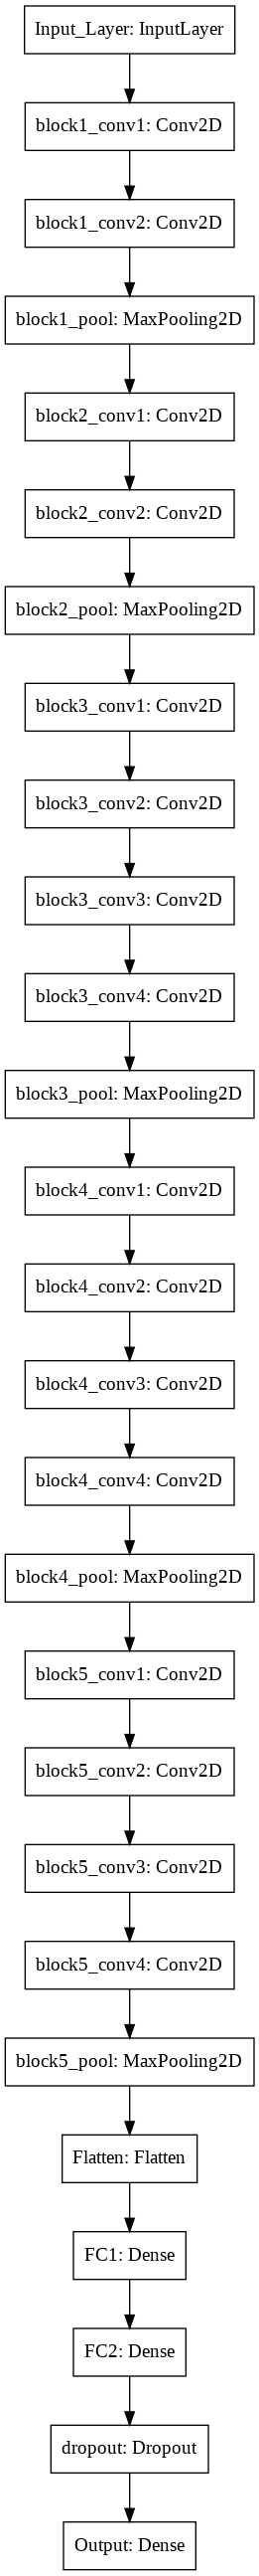

In [79]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [85]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage3_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [86]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [87]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [88]:
model.fit(train_generator   ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9995
Epoch 00001: val_accuracy improved from -inf to 0.58480, saving model to vgg19/vgg19_stage3_all-0.585.hdf5
245/244 [==============================] - 57s 231ms/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 2.0782 - val_accuracy: 0.5848
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9918
Epoch 00002: val_accuracy did not improve from 0.58480
245/244 [==============================] - 55s 225ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 2.1083 - val_accuracy: 0.5848
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9964
Epoch 00003: val_accuracy did not improve from 0.58480
245/244 [==============================] - 55s 226ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 2.0100 - val_accuracy: 0.5731
Epoch 4/50
245/244 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.99

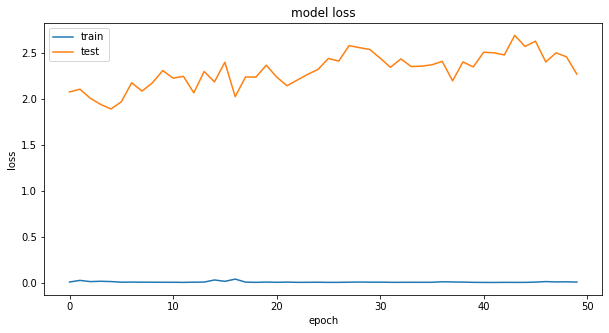

The loss for final model is  2.3112077713012695


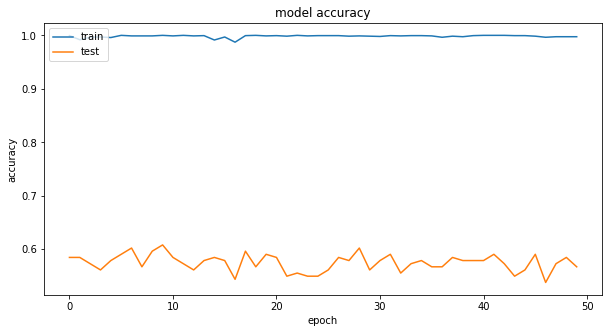

The accuracy for final model is  0.6081871390342712


In [89]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [91]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [92]:
best_model = load_model('vgg19/vgg19_stage3_all-0.608.hdf5')

In [93]:
y_pred = best_model.predict(x_test)

In [94]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6084597360956961
Average Recall is 0.5866310160427807
-------------------------------------------------- Confusion Matrix --------------------------------------------------


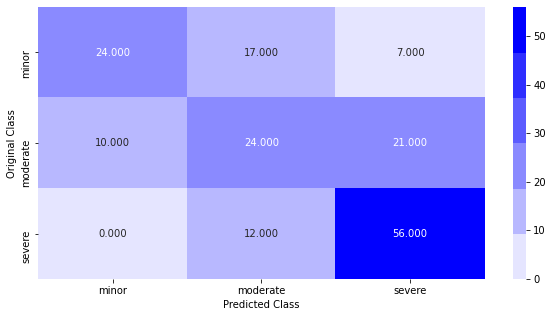

-------------------------------------------------- Precision Matrix --------------------------------------------------


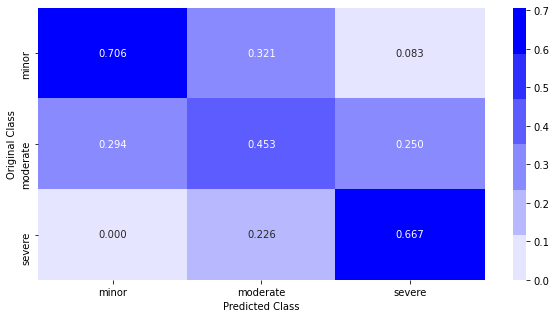

-------------------------------------------------- Recall Matrix --------------------------------------------------


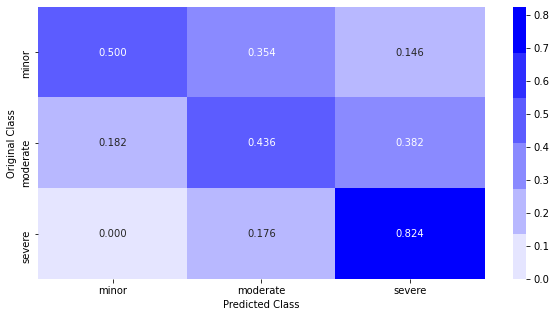

In [95]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [95]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage3 all','Accuracy':'0.608','Precision':'0.608','Recall':'0.587'},ignore_index= True)

In [96]:
vgg19_scores.to_csv('vgg19_scores.csv',index=False)